# Capstone Project - The Battle of Neighborhoods**

**Open new Turkish Restaurant in Bucharest, Romania**


###  Introduction

*In this project, I will determine which place is good for opening Turkish Restaurant in Bucharest, Romania*

    I will convert address data into their equivalent latitude and longitude values.
    For Bucharest neighborhood data, I will use wikipedia , https://en.wikipedia.org/wiki/Category:Districts of Bucharest
    I will use the Foursquare API to explore Bucharest neighborhoods and to get venues in neighborhoods.
    I will use the Foursquare API to get venue ratings and likes in neighborhoods.
    I will use the k-means clustering and Agglomerative algorithms to complete clustering task
    I will use the Folium library to visualize the neighborhoods, venues , clusters in Bucharest



**1. Download and Explore Neigborhood Dataset**

In [3]:
#install libraries 
!pip install geopy    
!pip install folium   
!pip install geocoder

     |████████████████████████████████| 94 kB 5.8 MB/s  eta 0:00:01
     |████████████████████████████████| 98 kB 8.4 MB/s  eta 0:00:01


In [4]:
#import libraries 
import numpy as np # library to handle data in a vectorized manner

import pandas as pd # library for data analsysis
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import matplotlib.pyplot as plt # for graphical usage 

import json # library to handle JSON files

from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

from geopy.geocoders import Nominatim # convert an address into latitude and longitude values
import geocoder # to get coordinates

import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

# import k-means from clustering stage
from sklearn.cluster import KMeans

import folium # map rendering library
from folium import plugins
from folium.plugins import HeatMap

# main documentation page: http://beautiful-soup-4.readthedocs.io/en/latest/
# how to use the BeautifulSoup package: https://www.youtube.com/watch?v=ng2o98k983k video
from bs4 import BeautifulSoup 
import pandas as pd
import requests

print('Libraries imported.')

Libraries imported.


In [5]:
# get coordinates of Bucharest
bucharest_address = 'Bucharest, Romania'

geolocator = Nominatim(user_agent="bucharest_explorer")
location = geolocator.geocode(bucharest_address)
latitude = location.latitude
longitude = location.longitude
bucharest_center = [latitude, longitude ]
print('The geograpical coordinate of {} are {}, {}.'.format(bucharest_address, latitude, longitude))

The geograpical coordinate of Bucharest, Romania are 44.4361414, 26.1027202.


In [6]:
# Read Bucharest neighborhood data 
url = "https://en.wikipedia.org/wiki/Category:Districts of Bucharest"
source = requests.get(url).text
soup = BeautifulSoup(source,'lxml')

neighborhoodList = []

# append the data into the list
for row in soup.find_all("div", class_="mw-category")[0].findAll("li"):
    neighborhoodList.append(row.text.replace(', Bucharest',''))
    
df_neighborhood = pd.DataFrame({"Neighborhood": neighborhoodList})
print("There are {} neighborhoods in {}".format(df_neighborhood.shape[0], bucharest_address))

There are 40 neighborhoods in Bucharest, Romania


In [7]:
# Read Bucharest sector data from wikipedia
url = "https://en.wikipedia.org/wiki/Sectors of Bucharest"
source = requests.get(url).text
soup = BeautifulSoup(source,'lxml')

sectorPopList = []
sectorPopulationList = []

for row in soup.find_all("tbody"):
    header = str(row.findAll("th"))
    if "Population (October 2011)" in header:
        i = 0
        for td in row.find_all("td"):
            i+=1
            if i==2: 
                sectorPopList.append(td.text.replace("\n",""))
            if i==3: 
                sectorPopulationList.append(td.text.replace("\n",""))    
                i=0

df_sectorPop = pd.DataFrame({"Sector": sectorPopList, "Population": sectorPopulationList})

sectorNeigList =[]
sectorNeigborList =[]

for row in soup.find_all("ul"):
    if sectorPopList[0] in  row.text:
        for s in row.text.split("\n"):
            sectorNeigList.append(s.split(":")[0])
            sectorNeigborList.append(s.split(":")[1])
    
df_sector= pd.DataFrame({"Sector": sectorNeigList, "Neigborhoods": sectorNeigborList}).merge(df_sectorPop,on='Sector' )

print("There are {} Sector in {}".format(df_sector.shape[0], bucharest_address))
df_sector

There are 6 Sector in Bucharest, Romania


,Sector,Neigborhoods,Population
0,Sector 1,"Dorobanți, Băneasa, Aviației, Pipera, Aviator...","225,454"
1,Sector 2,"Pantelimon, Colentina, Iancului, Tei, Floreas...","345,370"
2,Sector 3,"Vitan, Dudești, Titan, Centrul Civic, Balta A...","385,439"
3,Sector 4,"Berceni, Olteniței, Văcărești, Timpuri Noi, T...","287,828"
4,Sector 5,"Rahova, Ferentari, Giurgiului, Cotroceni, 13 ...","271,575"
5,Sector 6,"Giulești, Crângași, Drumul Taberei, Militari,...","367,760"


In [8]:
def getSector(row):
    for i in range(df_sector.shape[0]):
        if row["Neighborhood"] in  df_sector.iloc[i].Neigborhoods:
            return pd.Series([df_sector.iloc[i].Sector, df_sector.iloc[i].Population], index = ['Sector','SectorPopulation'])

df_neighborhood[["Sector","SectorPopulation"]] =df_neighborhood.apply(getSector, axis=1)
df_neighborhood.head(5)

,Neighborhood,Sector,SectorPopulation
0,Aviației,Sector 1,"225,454"
1,Băneasa,Sector 1,"225,454"
2,Berceni,Sector 4,"287,828"
3,Bucureștii Noi,Sector 1,"225,454"
4,Centrul Civic,Sector 3,"385,439"


In [9]:
# define a function to get coordinates
def get_latlng(neighborhood):
    # initialize your variable to None
    lat_lng_coords = None
    # loop until you get the coordinates
    while(lat_lng_coords is None):
        g = geocoder.arcgis('{}, {}'.format(neighborhood,bucharest_address))
        lat_lng_coords = g.latlng
    return lat_lng_coords

coords = [ get_latlng(neighborhood) for neighborhood in df_neighborhood["Neighborhood"].tolist() ]

df_coords = pd.DataFrame(coords, columns=['Latitude', 'Longitude'])

# merge the coordinates into the original dataframe
df_neighborhood['Latitude'] = df_coords['Latitude']
df_neighborhood['Longitude'] = df_coords['Longitude']
print("Geographical coordinates of five neighborhoods are as below")
df_neighborhood.head()

Geographical coordinates of five neighborhoods are as below


,Neighborhood,Sector,SectorPopulation,Latitude,Longitude
0,Aviației,Sector 1,"225,454",44.48579,26.101220
1,Băneasa,Sector 1,"225,454",44.49401,26.080372
2,Berceni,Sector 4,"287,828",44.38620,26.128960
3,Bucureștii Noi,Sector 1,"225,454",44.48842,26.036494
4,Centrul Civic,Sector 3,"385,439",44.43430,26.094660


In [10]:
#create map of Bucharest neighborhoods using latitude and longitude values
map_bucharest= folium.Map(location=[latitude, longitude], zoom_start=11)

# add markers to map
for lat, lng,  neighborhood in zip(df_neighborhood['Latitude'], df_neighborhood['Longitude'], df_neighborhood['Neighborhood']):
    label = '{}'.format(neighborhood)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_bucharest)  
    
map_bucharest


Explore Venues of Bucharest neighborhoods

I get venue list with 1 km distance to neighborhood's center


In [15]:
LIMIT = 100
CLIENT_ID = "XZSFE1FCJ4V2WNQ1WD11AV2II2AX13W4JJRPJYZDLYSP43DO"
CLIENT_SECRET = "PQXZHB1K1PXTKORNSEIHVTRWT1VPGLWXABJSSTL2NRD0MOCK"
VERSION = 20210116
def getNeighborhoodVenues( latitude, longitude,neighborhood, radius=1000 ):
    venues = []
    for lat, long, neighborhood in zip(latitude, longitude ,neighborhood):

        # create the API request URL
        url = "https://api.foursquare.com/v2/venues/explore?client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}".format(
            CLIENT_ID,
            CLIENT_SECRET,
            VERSION,
            lat,
            long,
            radius, 
            LIMIT)

        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']

        # return only relevant information for each nearby venue
        for venue in results:
            venues.append((
                neighborhood,
                lat, 
                long, 
                venue['venue']['name'], 
                venue['venue']['id'], 
                venue['venue']['location']['lat'], 
                venue['venue']['location']['lng'],  
                venue['venue']['location']['distance'],  
                venue['venue']['categories'][0]['name']))
    
    # convert the venues list into a DataFrame
    venues = pd.DataFrame(venues)
    # define the column names
    venues.columns = ['Neighborhood', 'Latitude', 'Longitude', 'VenueName', 'VenueId', 'VenueLatitude', 'VenueLongitude','VenueDistance','VenueCategory']
            
    return venues 

neighborhood_venues = getNeighborhoodVenues (df_neighborhood['Latitude'], df_neighborhood['Longitude'], df_neighborhood['Neighborhood'] )

print('There are {} unique venue categories. Some of them are as below:'.format(len(neighborhood_venues['VenueCategory'].unique())))
neighborhood_venues.head()

There are 218 unique venue categories. Some of them are as below:


,Neighborhood,Latitude,Longitude,VenueName,VenueId,VenueLatitude,VenueLongitude,VenueDistance,VenueCategory
0,Aviației,44.48579,26.10122,LIDL,583956246d349d0574eb02ac,44.488396,26.094375,616,Supermarket
1,Aviației,44.48579,26.10122,ibis Styles Bucharest Erbas,5bbb782175dcb7002cc15ee7,44.483963,26.097134,382,Hotel
2,Aviației,44.48579,26.10122,Mega Image Concept Store,56348b62498e53f51a0a4e0e,44.479783,26.102568,677,Supermarket
3,Aviației,44.48579,26.10122,ORYGYNS Specialty Coffee,5807575ed67ca95d8cf5ccb9,44.480010,26.100450,646,Coffee Shop
4,Aviației,44.48579,26.10122,Starbucks,525fd077498eed1c5a52c1d6,44.478522,26.102503,815,Coffee Shop


In [16]:
print('Top 10 distinct venue counts are as below')
neighborhood_venues[['VenueId','VenueCategory']].drop_duplicates().groupby('VenueCategory').count()[['VenueId']].rename(columns={"VenueId": "Count"}).sort_values(by=['Count'], ascending=False)[:10]

Top 10 distinct venue counts are as below


,Count
VenueCategory,
Restaurant,65
Café,65
Coffee Shop,63
Supermarket,53
Italian Restaurant,48
Pizza Place,45
Gym,39
Park,37
Hotel,37


In [17]:
restaurant_list =['Restaurant', 'Burger Joint','Café','Fried Chicken Joint','Pizza Place']
turkish_restaurant_list = ['Turkish Restaurant', 'Doner Restaurant']

# Filter restaurants 
    
neighborhood_venues['RestFlag']=False
for restCat in restaurant_list:
    neighborhood_venues['RestFlag'] = neighborhood_venues['RestFlag'] | neighborhood_venues['VenueCategory'].str.contains(restCat)
    
neighborhood_restaurants = neighborhood_venues[neighborhood_venues['RestFlag'] == True].iloc[:,:-1]
turkish_restaurants = neighborhood_restaurants[ neighborhood_restaurants['VenueCategory'].isin(turkish_restaurant_list) ]
other_restaurants = neighborhood_restaurants[ ~neighborhood_restaurants['VenueCategory'].isin(turkish_restaurant_list) ]

print('Total number of restaurants:', len(neighborhood_restaurants['VenueId'].unique()))
print('Total number of Turkish restaurants:', len(turkish_restaurants['VenueId'].unique()))
print('Percentage of Turkish restaurants: {:.2f}%'.format(len(turkish_restaurants['VenueId'].unique()) / len(neighborhood_restaurants['VenueId'].unique()) * 100))

Total number of restaurants: 470
Total number of Turkish restaurants: 21
Percentage of Turkish restaurants: 4.47%


20 neighborhoods do not have any Turkish restaurant


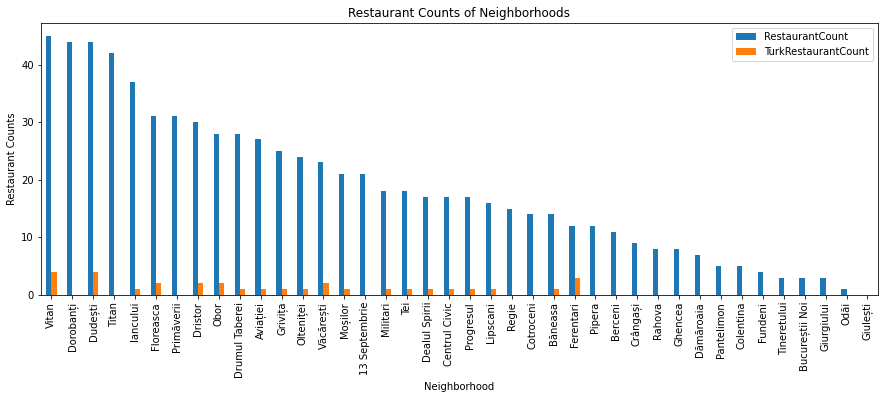

In [18]:
# get counts of restaurants in each Neighborhood
df_rest_counts =  neighborhood_restaurants.groupby(['Neighborhood']).count().rename(columns={"VenueCategory": "RestaurantCount"})[['RestaurantCount']]

#find neighborhoods that does not have any restaurant 
noRestList = list(set(neighborhood_venues['Neighborhood']) - set(neighborhood_restaurants['Neighborhood']))

#if exists , append neighborhoods without any restaurant to df_rest_counts
if noRestList != []:
    df_rest_counts = df_rest_counts.append (pd.DataFrame( {'Neighborhood' : noRestList  , 'RestaurantCount': [0] * len(noRestList) } ).set_index('Neighborhood'))

df_rest_counts.reset_index(inplace=True)

#####
# get counts of Turkish restaurants in each Neighborhood
df_turk_rest_counts =  turkish_restaurants.groupby(['Neighborhood']).count().rename(columns={"VenueCategory": "TurkRestaurantCount"})[['TurkRestaurantCount']]

#find neighborhoods that does not have any restaurant 
noRestList = list(set(neighborhood_venues['Neighborhood']) - set(turkish_restaurants['Neighborhood']))

#if exists , append neighborhoods without any restaurant to df_rest_counts
if noRestList != []:
    df_turk_rest_counts = df_turk_rest_counts.append (pd.DataFrame( {'Neighborhood' : noRestList  , 'TurkRestaurantCount': [0] * len(noRestList) } ).set_index('Neighborhood'))

df_turk_rest_counts.reset_index(inplace=True)
df_rest_counts= df_rest_counts.merge(df_turk_rest_counts).set_index('Neighborhood')
df_rest_counts= df_rest_counts.sort_values(by=['RestaurantCount'],ascending =False)

print('{} neighborhoods do not have any Turkish restaurant'.format(len(noRestList)))
######
#Draw graph
df_rest_counts[['RestaurantCount','TurkRestaurantCount']].plot(kind='bar',figsize=(15,5))
plt.title('Restaurant Counts of Neighborhoods')
plt.xlabel('Neighborhood')
plt.ylabel('Restaurant Counts')
plt.show()



### We can see from the Graph :

    Vitan is the neihgborhood having most restaurants
    Dorobanti is has lots of restaurants , but no Tukish restaurant
    Odai and Gluesti are neihgborhoods having least number of restaurants
    19 neihgborhoods do not have any Turkish restaurant. we can choose one of these to open resaturant. To filter more let's continue


## Get the restaurant's overall rating

I used Foursquare API for getting likes and rates of restaurants


In [20]:
def getVenueRaitings(venues):
    
    raitings = []
    likes =[]
    for venueId in venues:

        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/{}?client_id={}&client_secret={}&v={}'.format(venueId, CLIENT_ID, CLIENT_SECRET, VERSION)
        result = requests.get(url).json()
        try:
            rating = result['response']['venue']['rating']
            likes = result['response']['venue']['likes']['count']
        except:
            rating = None
            likes = None
        
        raitings.append((venueId, rating,likes))
 
    # convert the venues list into a DataFrame
    rating = pd.DataFrame(raitings)
    # define the column names
    rating.columns = ['VenueId', 'VenueRating','VenueLikes']

    return rating    

restaurants_raitings = getVenueRaitings(neighborhood_restaurants['VenueId'].drop_duplicates())
restaurants_raitings.head()

,VenueId,VenueRating,VenueLikes
0,58a2fc95d0bb3e516a2363b7,None,None
1,53623e44498ed583ede334f5,None,None
2,55b8a459498efbbb6ca3526d,None,None
3,58bbf8764f1069627380fed5,None,None
4,5265321211d253acd6745862,None,None


In [21]:
#merge raitings to restaurants 
neighborhood_restaurants = neighborhood_restaurants.merge(restaurants_raitings)
neighborhood_restaurants.head()

,Neighborhood,Latitude,Longitude,VenueName,VenueId,VenueLatitude,VenueLongitude,VenueDistance,VenueCategory,VenueRating,VenueLikes
0,Aviației,44.48579,26.101220,Flying Pig,58a2fc95d0bb3e516a2363b7,44.479454,26.102837,716,Burger Joint,None,None
1,Floreasca,44.47633,26.103279,Flying Pig,58a2fc95d0bb3e516a2363b7,44.479454,26.102837,349,Burger Joint,None,None
2,Aviației,44.48579,26.101220,trickSHOT,53623e44498ed583ede334f5,44.478378,26.103135,838,Restaurant,None,None
3,Floreasca,44.47633,26.103279,trickSHOT,53623e44498ed583ede334f5,44.478378,26.103135,228,Restaurant,None,None
4,Aviației,44.48579,26.101220,Toàn's,55b8a459498efbbb6ca3526d,44.478370,26.103411,844,Vietnamese Restaurant,None,None


In [22]:
#merge raitings to turkish restaurants 
turkish_restaurants = turkish_restaurants.merge(restaurants_raitings)
turkish_restaurants.head(5)


,Neighborhood,Latitude,Longitude,VenueName,VenueId,VenueLatitude,VenueLongitude,VenueDistance,VenueCategory,VenueRating,VenueLikes
0,Aviației,44.485790,26.101220,Istanbul Taksim,55acc94f498e0a64af6b19af,44.478560,26.103505,825,Turkish Restaurant,None,None
1,Floreasca,44.476330,26.103279,Istanbul Taksim,55acc94f498e0a64af6b19af,44.478560,26.103505,248,Turkish Restaurant,None,None
2,Băneasa,44.494010,26.080372,Shaormeria Băneasa,5137a298e4b0523475c45b54,44.494460,26.080462,50,Doner Restaurant,None,None
3,Centrul Civic,44.434300,26.094660,Dristor Kebap,4dc58dd7887717c8802694a1,44.430054,26.100384,656,Doner Restaurant,None,None
4,Lipscani,44.432155,26.104091,Dristor Kebap,4dc58dd7887717c8802694a1,44.430054,26.100384,376,Doner Restaurant,None,None



**Show restaurants on head map**

Let's crete a map showing heatmap / density of restaurants and try to extract some meaningfull info from that. Also, let's show borders of Bucharest on our map and a few circles indicating distance of 2km, 4km, 6km and 10km from Bucharest center

Red markers are Turkish restaurants

Blue markers are Turkish restaurants with rating less than 7 restaurants


In [24]:
bucharest_center = [latitude, longitude]
map_restaurant= folium.Map(location=bucharest_center, zoom_start=12)
df_neighborhood_noturkrest = df_neighborhood[df_neighborhood['Neighborhood'].isin(noRestList)]

folium.TileLayer('cartodbpositron').add_to(map_bucharest) 
HeatMap(neighborhood_restaurants[['VenueLatitude','VenueLongitude']]).add_to(map_restaurant)
folium.Marker(bucharest_center).add_to(map_bucharest)
folium.Circle(bucharest_center, radius=2000, fill=False, color='white').add_to(map_restaurant)
folium.Circle(bucharest_center, radius=4000, fill=False, color='white').add_to(map_restaurant)
folium.Circle(bucharest_center, radius=6000, fill=False, color='white').add_to(map_restaurant)
folium.Circle(bucharest_center, radius=10000, fill=False, color='black').add_to(map_restaurant)
for lat, lon, neig, name in zip(turkish_restaurants['VenueLatitude'], turkish_restaurants['VenueLongitude'], turkish_restaurants['Neighborhood'], turkish_restaurants['VenueName']):
    label = folium.Popup(str(name) + ' - ' + str(neig), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color='red',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7).add_to(map_restaurant)
       
raiting_lt_7 = turkish_restaurants[turkish_restaurants['VenueRating'] <7]
for lat, lon, neig, name in zip(raiting_lt_7['VenueLatitude'], raiting_lt_7['VenueLongitude'], raiting_lt_7['Neighborhood'], raiting_lt_7['VenueName']):
    label = folium.Popup(str(name) + ' - ' + str(neig), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7).add_to(map_restaurant)        
map_restaurant


From heat map , we can see that there are

    Too many restaurants in 4 km to the center
    Enough restaurants between 4-6 km to the center
    There are not many restaurants after 6 km to center
    Turkish restaurants are superimposed with red and blue dots. Blue dots are Turkish restaurant with raiting <7
    Turkish restaurants are located in South, North , East, between 2-4 Km distance around center
    There are not Turkish Restaurants in West Part.
    3 Turkish restaurants gets bad points. That means people does not prefer these restaurant too much and any turkish restaurant may be opened around

Show neighborhoods which has no Turkish restaurant on head map

Cyan markers are Neigborhoods without any turkish restaurants


In [25]:
bucharest_center = [latitude, longitude]
map_restaurant= folium.Map(location=bucharest_center, zoom_start=12)

df_neighborhood_noturkrest = df_neighborhood[df_neighborhood['Neighborhood'].isin(noRestList)]

folium.TileLayer('cartodbpositron').add_to(map_bucharest) 
HeatMap(neighborhood_restaurants[['VenueLatitude','VenueLongitude']]).add_to(map_restaurant)
folium.Marker(bucharest_center).add_to(map_bucharest)
folium.Circle(bucharest_center, radius=2000, fill=False, color='white').add_to(map_restaurant)
folium.Circle(bucharest_center, radius=4000, fill=False, color='white').add_to(map_restaurant)
folium.Circle(bucharest_center, radius=6000, fill=False, color='white').add_to(map_restaurant)
folium.Circle(bucharest_center, radius=10000, fill=False, color='black').add_to(map_restaurant)
for lat, lon, neig in zip(df_neighborhood_noturkrest['Latitude'], df_neighborhood_noturkrest['Longitude'], df_neighborhood_noturkrest['Neighborhood']):
    label = folium.Popup(str(neig), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color='cyan',
        fill=True,
        fill_color='cyan',
        fill_opacity=0.7).add_to(map_restaurant)
map_restaurant

# 3. Cluster Neigborhoods using Agglomerative Clustering

In [26]:
# one hot encoding
onehot = pd.get_dummies(neighborhood_venues[['VenueCategory']], prefix="", prefix_sep="")
# add neighborhood column back to dataframe
onehot['Neighborhood'] = neighborhood_venues['Neighborhood']

venues_grouped = onehot.groupby(["Neighborhood"]).sum().reset_index()

# move neighborhood column to the first column and filter only restaurant columns 
fixed_columns =['Neighborhood'] + list(neighborhood_venues['VenueCategory'].unique())
venues_grouped = venues_grouped[fixed_columns]

print("{}  neighborhoods' venue category are shown in {} columns as below".format(venues_grouped.shape[0],venues_grouped.shape[1]-1))
venues_grouped.head()

40  neighborhoods' venue category are shown in 218 columns as below


,Neighborhood,Supermarket,Hotel,Coffee Shop,Burger Joint,Dessert Shop,Roof Deck,Gym / Fitness Center,Restaurant,Vietnamese Restaurant,Salad Place,Pie Shop,Grocery Store,Beer Garden,Café,Salon / Barbershop,Shopping Mall,Bookstore,Steakhouse,Italian Restaurant,Toy / Game Store,Clothing Store,Sushi Restaurant,Lebanese Restaurant,Turkish Restaurant,Bakery,Sandwich Place,Casino,Spanish Restaurant,Pizza Place,Event Space,Indoor Play Area,Veterinarian,Eastern European Restaurant,Lounge,Fried Chicken Joint,Stadium,Tennis Stadium,Romanian Restaurant,Skating Rink,Sporting Goods Shop,Cocktail Bar,Gym,Middle Eastern Restaurant,Doner Restaurant,Vegetarian / Vegan Restaurant,Lake,Park,Nightclub,Tunnel,Theme Restaurant,Farmers Market,Bus Stop,Airport Terminal,Food & Drink Shop,Nature Preserve,Fast Food Restaurant,Soccer Field,Jewelry Store,Metro Station,Gas Station,Theater,Pharmacy,Cupcake Shop,Mexican Restaurant,Gym Pool,Mobile Phone Shop,Shop & Service,Korean Restaurant,Gastropub,Bistro,Outdoor Sculpture,Monastery,Indie Theater,Ice Cream Shop,Used Bookstore,Chocolate Shop,Tea Room,Art Museum,Plaza,Bar,Concert Hall,Wine Bar,Cosmetics Shop,French Restaurant,Beer Bar,Boutique,Swiss Restaurant,Rock Club,Hostel,Art Gallery,Breakfast Spot,Historic Site,Church,Tattoo Parlor,Greek Restaurant,Hardware Store,Discount Store,Arts & Crafts Store,Auto Dealership,Herbs & Spices Store,Bus Station,Gift Shop,Tennis Court,Jazz Club,Accessories Store,Market,Opera House,Pedestrian Plaza,Garden,Hotel Bar,Indian Restaurant,Pub,Music Store,Spa,Pool,Indie Movie Theater,Australian Restaurant,Skate Park,Buffet,Light Rail Station,Furniture / Home Store,Electronics Store,Department Store,Climbing Gym,Soccer Stadium,Miscellaneous Shop,Convenience Store,Donut Shop,Outlet Mall,Intersection,Japanese Restaurant,Fish Market,Scandinavian Restaurant,Juice Bar,Cheese Shop,Mediterranean Restaurant,Asian Restaurant,Creperie,Modern European Restaurant,Seafood Restaurant,German Restaurant,Fruit & Vegetable Store,Molecular Gastronomy Restaurant,Wine Shop,American Restaurant,Drugstore,Auto Workshop,Pet Store,Multiplex,Eye Doctor,Chinese Restaurant,Currency Exchange,Women's Store,Arts & Entertainment,Shoe Store,Water Park,Brewery,Tourist Information Center,Bed & Breakfast,Health Food Store,Diner,Flower Shop,Platform,Health & Beauty Service,Bagel Shop,Portuguese Restaurant,Science Museum,Lingerie Store,Athletics & Sports,Sports Club,Tram Station,Boxing Gym,Museum,History Museum,Food Truck,Movie Theater,Kebab Restaurant,Exhibit,Snack Place,Public Art,Pool Hall,Gourmet Shop,Camera Store,Fountain,Bridal Shop,Big Box Store,BBQ Joint,Hungarian Restaurant,Karaoke Bar,Beach,Auto Garage,Bowling Alley,Go Kart Track,Food Court,Palace,Track,Bike Shop,Recreation Center,Dog Run,Bike Rental / Bike Share,Basketball Court,Paper / Office Supplies Store,Sports Bar,Waterfront,Laundromat,Business Service,Kids Store,Comfort Food Restaurant,Taco Place,Fish & Chips Shop,Racetrack,Playground,Smoke Shop,ATM,Soup Place,Hookah Bar,Circus,Falafel Restaurant
0,13 Septembrie,0,2,1,0,1,0,2,5,0,0,0,0,0,3,0,0,0,1,1,0,1,0,0,0,1,1,1,0,0,0,0,0,1,2,1,0,0,2,0,0,1,1,0,0,0,0,1,0,0,0,1,0,0,1,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,2,1,4,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,0,0,0,0,1,1,3,0,1,0,0,0,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,2,1,1,1,0,0,0,0,0,0,0
1,Aviației,4,4,4,3,3,1,2,5,1,1,1,1,1,5,1,1,1,2,1,1,3,2,2,1,3,1,1,1,3,1,1,1,1,1,1,1,1,1,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,Berceni,1,0,0,0,0,0,2,0,0,0,0,2,1,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,3,0,0,0,

In [27]:
# create a new dataframe with most common venue catrgories
def return_most_common_venues(row, num_top_venues):
    row_categories = row
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

num_top_venues = 10

columns = ['Neighborhood','Total Number of Venues']
indicators = ['st', 'nd', 'rd']
# create columns according to number of top venues

for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Restaurant'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Restaurant'.format(ind+1))

# create a new dataframe
venues_most = pd.DataFrame(columns = columns)

for ind in range(venues_grouped.shape[0]):
    venues_most.loc[ind, 'Neighborhood'] = venues_grouped.iloc[ind].Neighborhood
    venues_most.loc[ind, 'Total Number of Venues'] = venues_grouped.iloc[ind,1:].sum()
    venues_most.iloc[ind, 2:] = return_most_common_venues(venues_grouped.iloc[ind, 1:], num_top_venues)

venues_most.head()

,Neighborhood,Total Number of Venues,1st Most Common Restaurant,2nd Most Common Restaurant,3rd Most Common Restaurant,4th Most Common Restaurant,5th Most Common Restaurant,6th Most Common Restaurant,7th Most Common Restaurant,8th Most Common Restaurant,9th Most Common Restaurant,10th Most Common Restaurant
0,13 Septembrie,67,Restaurant,Plaza,Café,Pub,Romanian Restaurant,Lounge,Gym / Fitness Center,Comfort Food Restaurant,Tea Room,Light Rail Station
1,Aviației,73,Restaurant,Café,Supermarket,Hotel,Coffee Shop,Bakery,Clothing Store,Pizza Place,Burger Joint,Dessert Shop
2,Berceni,23,Eastern European Restaurant,Pizza Place,Grocery Store,Romanian Restaurant,Gym / Fitness Center,Lebanese Restaurant,Park,Farmers Market,Café,Beer Garden
3,Bucureștii Noi,23,Supermarket,Pharmacy,Shop & Service,Park,Gym,Bakery,Gas Station,Theater,Cupcake Shop,Mexican Restaurant
4,Băneasa,30,Restaurant,Italian Restaurant,Park,Romanian Restaurant,Hotel,Indoor Play Area,Middle Eastern Restaurant,Pizza Place,Doner Restaurant,Gym


**Cluster and find similarities between neighborhoods**

I will use hierarchical agglomerative clustering method to compare neighborhoods among neighborhoods

First, find the number of clusters. Let's use scipy library to create the dendrograms for our dataset


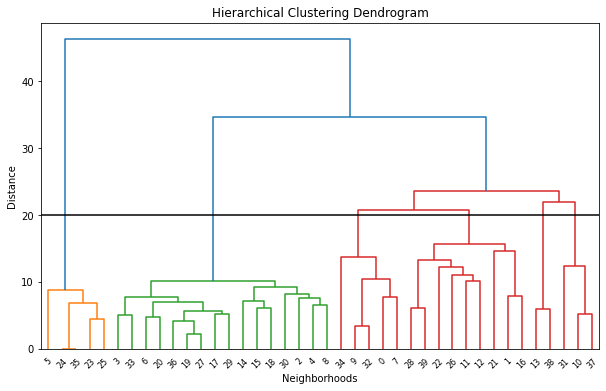

In [28]:
import scipy.cluster.hierarchy as shc

data = venues_grouped.iloc[:,3:]
plt.figure(figsize=(10, 6))   
plt.title('Hierarchical Clustering Dendrogram')
plt.xlabel('Neighborhoods')
plt.ylabel('Distance')
plt.axhline(y=20, c='k')
dend = shc.dendrogram(shc.linkage(data, method='ward'))

According to the above graph, I decide to separate our neighborhoods into 6 clusters (cut at distance of 20, horizontal black line). I will use the hierarchical agglomerative clustering of the sklearn.cluster library to cluster these neighborhoods.

In [29]:
from sklearn.cluster import AgglomerativeClustering

kclusters= 6
cluster = AgglomerativeClustering(n_clusters=kclusters, affinity='euclidean', linkage='ward')  
clusterresult = cluster.fit_predict(data)

venues_grouped['NeighborhoodCluster'] = clusterresult
venues_cluster= df_neighborhood.merge(venues_grouped[['Neighborhood','NeighborhoodCluster']])
venues_cluster =venues_cluster.merge(venues_most[['Neighborhood','1st Most Common Restaurant','2nd Most Common Restaurant','3rd Most Common Restaurant']])
venues_cluster.head()

,Neighborhood,Sector,SectorPopulation,Latitude,Longitude,NeighborhoodCluster,1st Most Common Restaurant,2nd Most Common Restaurant,3rd Most Common Restaurant
0,Aviației,Sector 1,"225,454",44.48579,26.101220,0,Restaurant,Café,Supermarket
1,Băneasa,Sector 1,"225,454",44.49401,26.080372,5,Restaurant,Italian Restaurant,Park
2,Berceni,Sector 4,"287,828",44.38620,26.128960,5,Eastern European Restaurant,Pizza Place,Grocery Store
3,Bucureștii Noi,Sector 1,"225,454",44.48842,26.036494,5,Supermarket,Pharmacy,Shop & Service
4,Centrul Civic,Sector 3,"385,439",44.43430,26.094660,3,Coffee Shop,Hotel,Wine Bar


In [30]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i+x+(i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
for lat, lon, poi, cluster, sector,SectorPopulation  in zip(venues_cluster['Latitude'], venues_cluster['Longitude'], venues_cluster['Neighborhood'], venues_cluster['NeighborhoodCluster'], venues_cluster['Sector'],venues_cluster['SectorPopulation']):
    label = folium.Popup(str(poi) + ' - Cluster ' + str(cluster)+ ' ' + str(sector) + ' ' + str(SectorPopulation), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
folium.Marker(bucharest_center).add_to(map_clusters)
folium.Circle(bucharest_center, radius=2000, fill=False, color='white').add_to(map_clusters)
folium.Circle(bucharest_center, radius=4000, fill=False, color='white').add_to(map_clusters)
folium.Circle(bucharest_center, radius=6000, fill=False, color='white').add_to(map_clusters)
folium.Circle(bucharest_center, radius=10000, fill=False, color='black').add_to(map_clusters)         
map_clusters

In [31]:
print(venues_cluster.groupby(['NeighborhoodCluster','1st Most Common Restaurant' ]).count()[['Neighborhood']].rename(columns={"Neighborhood": "Neighborhood Count"}))

venues_cluster.groupby(['NeighborhoodCluster','2nd Most Common Restaurant' ]).count()[['Neighborhood']].rename(columns={"Neighborhood": "Neighborhood Count"})

                                                 Neighborhood Count
NeighborhoodCluster 1st Most Common Restaurant                     
0                   Café                                          1
                    Coffee Shop                                   2
                    Italian Restaurant                            2
                    Pizza Place                                   1
                    Restaurant                                    1
                    Supermarket                                   2
1                   Café                                          1
                    Coffee Shop                                   2
2                   Bus Station                                   1
                    Pub                                           1
                    Restaurant                                    2
                    Supermarket                                   1
3                   Coffee Shop                 

Neighborhood Count
NeighborhoodCluster 2nd Most Common Restaurant                    
0                   Café                                         2
                    Gym                                          1
                    Hotel                                        1
                    Pharmacy                                     1
                    Pizza Place                                  2
                    Restaurant                                   1
                    Supermarket                                  1
1                   Café                                         1
                    Coffee Shop                                  1
                    Lounge                                       1
2                   Bus Station                                  1
                    Gym                                          1
                    Plaza                                        2
                    Supermarket                                  1
3                   Hotel                                        4
                    Restaurant                                   1
4                   Restaurant                                   1
                    Supermarket                                  1
5                   Burger Joint                                 2
                    Bus Station                                  3
                    Falafel Restaurant                           1
                    Furniture / Home Store                       1
                    Gym / Fitness Center                         1
                    Italian Restaurant                           1
                    Metro Station                                1
                    Pharmacy                                     1
                    Pizza Place                                  1
                    Pool                                         1
                    Restaurant                                   1
                    Salon / Barbershop                           1
                    Sandwich Place                               1

**We can see cluster categories as below**

Cluster 0 (Red) : Italian Restaurant , Pizza, Café
Cluster 1 (Purple) : Restaurant , Bar
Cluster 2 (BLue) : Park , Plaza, Clothing stores
Cluster 3 (Cyan) : Coffee Shop, Hotel, Pub
Cluster 4 (Green) : Café, Suprmarket
Cluster 5 (Orange) : Café 

# 4. Discussion



Cluster 2 suffers from restaurant. Especially there is no Turkish restaurant in west part inluding Cluster 2 . We can think about Cluster 2 , West part

Cluster 0 especially likes Itallian tastes , may be this part will not like Turkish tastes . We can only think about 1 location may be .

Cluster 1, 2, 3 are centers full of restaurants as we saw in the heatmap also


# 5. Conclusion

In [ ]:

ossible Neighborhoods to set up a Turkish restaurant :

• Neighborhood : Regie , Cluster 0, Sector 6 , Population : 367760

I choosed Regie , since west part of Bucharest has not Turkish restaurant and Regie is close to center . Regie is red cluster which is same with the other 2 red markers having Turk restaurant. Red clusters populations may like Turkish food. 

• Neighborhood : Bucureștii Noi , Cluster 2, Sector 1 , Population : 225453

I choosed Bucharest-noi , since west part of Bucharest has not Turkish restaurant and even not too much restaurant after 6 km distance to center . One restaurant will be good for this area.

• Neighborhood : Crângași , Cluster 2, Sector 6 , Population : 367760

I choosed Crangasi , since Crangasi  and west part of Bucharest has not Turkish restaurant and from bar chart we can see that this neighborhood has not too much restaurant. Also this neighborhood is in Sector 6 and this sector has biggest population which will handle one more restaurant 

• Neighborhood : Tineretului , Cluster 2, Sector 4 , Population : 287828

I choosed Tineretului , since Tineretului has not Turkish restaurant and from bar chart we can see that this neighborhood has not too much restaurant. 

